# Molecular Spectral Latent Modelling
- Jan Andrzejczyk
- Marcel Wilanowicz

In [2]:
%pip install torch torchvision torchaudio

  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 3.2 MB/s  0:00:23m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.3/807.3 kB 4.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.6 MB/s  0:00:00 eta 0:00:01
Using cached filelock-3.20.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [torchaudio]5 [torchvision]
Note: you may need to restart the kernel to use updated packages.


In [24]:
import selfies as sf
import pandas as pd
import glob
import os
import re
import csv
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [11]:
smi = 'COC'
selfie = sf.encoder(smi)
selfie

'[C][O][C]'

## Wczytanie i analiza struktury danych

In [ ]:
#### DON'T RUN THIS CELL AGAIN ####
''' Do wstępnej analizy załadowano losową próbkę k=10 plików, 
co odpowiada około 4% całego zbioru. '''

import random, glob, os, pandas as pd


DATA_DIR = "multimodal_spectroscopic_dataset"

# znajdź wszystkie pliki .parquet
paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet")))
print("Znaleziono plików:", len(paths))

# pobierz losową próbkę k=10
k = 10
sample_paths = random.sample(paths, k=k)

# wczytaj je i policz rekordy
dfs = []
rows_total = 0

for p in sample_paths:
    df = pd.read_parquet(p)
    dfs.append(df)
    print(os.path.basename(p), "->", len(df), "wierszy")
    rows_total += len(df)

data = pd.concat(dfs, ignore_index=True)

print("-" * 50)
print(f"Wczytano łącznie: {rows_total:,} rekordów z {k} plików.")
print("Średnia na plik:", rows_total / k)
print("Kolumny:", list(data.columns))

Znaleziono plików: 245
aligned_chunk_187.parquet -> 3283 wierszy
aligned_chunk_193.parquet -> 3242 wierszy
aligned_chunk_48.parquet -> 3177 wierszy
aligned_chunk_3.parquet -> 3226 wierszy
aligned_chunk_214.parquet -> 3238 wierszy
aligned_chunk_111.parquet -> 3210 wierszy
aligned_chunk_46.parquet -> 3261 wierszy
aligned_chunk_196.parquet -> 3201 wierszy
aligned_chunk_222.parquet -> 3241 wierszy
aligned_chunk_91.parquet -> 3263 wierszy
--------------------------------------------------
Wczytano łącznie: 32,342 rekordów z 10 plików.
Średnia na plik: 3234.2
Kolumny: ['smiles', 'hsqc_nmr_peaks', 'hsqc_nmr_spectrum', 'h_nmr_peaks', 'h_nmr_spectra', 'molecular_formula', 'c_nmr_peaks', 'ir_spectra', 'msms_positive_10ev', 'msms_positive_20ev', 'msms_positive_40ev', 'msms_fragments_positive', 'msms_negative_10ev', 'msms_negative_20ev', 'msms_negative_40ev', 'msms_fragments_negative', 'c_nmr_spectra']


W katalogu *multimodal_spectroscopic_dataset* znajduje się 245 plików w formacie .parquet.  
Losowa próbka 10 plików zawiera łącznie 32 441 rekordów (średnio ok. 3 200 rekordów na plik).  
Każdy rekord opisuje jedną cząsteczkę chemiczną i składa się z 17 kolumn:

| Kolumna | Opis |
|--------|------|
| smiles | struktura chemiczna w notacji SMILES |
| hsqc_nmr_peaks | lista pików widma HSQC NMR (pozycje 1H/13C, intensywności) |
| hsqc_nmr_spectrum | pełne widmo HSQC NMR w formie tablicy wartości |
| h_nmr_peaks | lista pików ¹H NMR (częstotliwości, integraly) |
| h_nmr_spectra | pełne widmo ¹H NMR jako wektor intensywności |
| molecular_formula | wzór sumaryczny cząsteczki (np. C19H9F5O4S) |
| c_nmr_peaks | lista pików ¹³C NMR |
| ir_spectra | widmo IR (absorbancja w funkcji liczby falowej) |
| msms_positive_10ev | widmo MS/MS w trybie dodatnim przy energii 10 eV |
| msms_positive_20ev | widmo MS/MS w trybie dodatnim przy energii 20 eV |
| msms_positive_40ev | widmo MS/MS w trybie dodatnim przy energii 40 eV |
| msms_fragments_positive | fragmenty jonów dodatnich z przypisanymi formułami |
| msms_negative_10ev | widmo MS/MS w trybie ujemnym przy energii 10 eV |
| msms_negative_20ev | widmo MS/MS w trybie ujemnym przy energii 20 eV |
| msms_negative_40ev | widmo MS/MS w trybie ujemnym przy energii 40 eV |
| msms_fragments_negative | fragmenty jonów ujemnych z przypisanymi formułami |
| c_nmr_spectra | pełne widmo ¹³C NMR |

### Wyjaśnienie terminologii

SMILES – tekstowa reprezentacja struktury chemicznej (atomy, wiązania, pierścienie zapisane jako ciąg znaków).

Molecular formula (wzór sumaryczny) – zlicza, ile atomów każdego pierwiastka zawiera cząsteczka (np. C15H12BrFN4).

NMR (nuclear magnetic resonance) – technika pozwalająca określić, jakie atomy znajdują się w cząsteczce i w jakim są otoczeniu chemicznym.  
- ¹H NMR – sygnały od protonów (atomów wodoru).  
- ¹³C NMR – sygnały od atomów węgla.  
- HSQC – widmo dwuwymiarowe ¹H–¹³C, które łączy protony z odpowiadającymi im atomami węgla.  
- Pik (peak) – pojedynczy sygnał w widmie.  
- Integral – obszar pod pikiem ¹H NMR; informuje, ile protonów daje dany sygnał.  
- Widmo (spectrum) – lista intensywności sygnału w funkcji częstotliwości (ppm).

IR (infrared spectroscopy) – widmo drgań cząsteczki; różne grupy funkcyjne pochłaniają promieniowanie IR w charakterystycznych miejscach, co pozwala je identyfikować.

MS/MS (tandem mass spectrometry) – technika, która rozbija cząsteczkę na fragmenty i mierzy ich masy.  
- m/z – stosunek masy do ładunku jonu.  
- Tryb dodatni/ujemny – sposób jonizacji (kationy lub aniony).  
- 10/20/40 eV – energia fragmentacji; wyższa energia daje więcej fragmentów.  
- Fragments – lista fragmentów z przypisanymi im formułami.

Każdy z tych typów danych pochodzi z innej techniki pomiarowej i opisuje inną właściwość tej samej cząsteczki. Zestaw zawiera tekstową strukturę, widma 1D, widma 2D, widma masowe oraz widmo IR, więc jest **multimodalny** (zawiera wiele modalności danych naraz).

In [13]:
def count_elements(smiles):
    els = re.findall(r"[A-Z][a-z]?", smiles)
    return len(set(els))

data["n_elements"] = data["smiles"].map(count_elements)
data["is_organic"] = data["smiles"].str.contains("C")
data["smiles_len"] = data["smiles"].str.len()

print("Udział organicznych:", data["is_organic"].mean()*100)
print("Mediana długości SMILES:", data["smiles_len"].median())
print("Mediana liczby pierwiastków:", data["n_elements"].median())

Udział organicznych: 99.57949415620556
Mediana długości SMILES: 39.0
Mediana liczby pierwiastków: 4.0


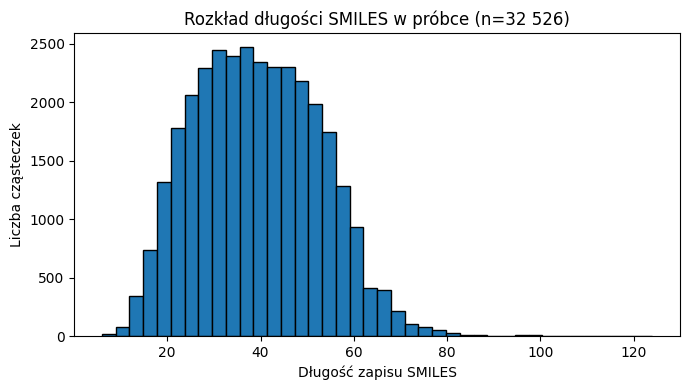

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(data["smiles_len"], bins=40, edgecolor="black")
plt.xlabel("Długość zapisu SMILES")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład długości SMILES w próbce (n=32 526)")
plt.tight_layout()
plt.savefig("smiles_length_hist.png", dpi=150)
plt.show()

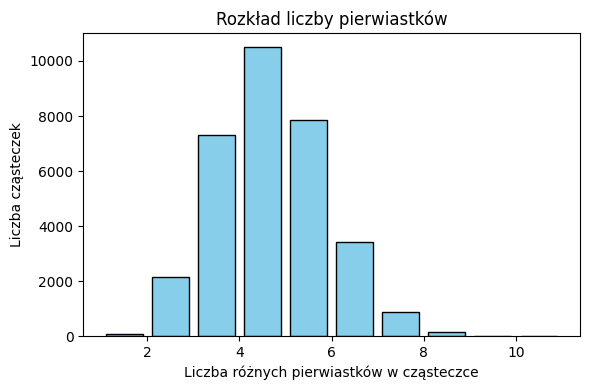

In [15]:
plt.figure(figsize=(6,4))
plt.hist(data["n_elements"].dropna(), bins=range(1,12), rwidth=0.8, color="skyblue", edgecolor="black")
plt.xlabel("Liczba różnych pierwiastków w cząsteczce")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład liczby pierwiastków")
plt.tight_layout()
plt.savefig("num_elements_hist.png", dpi=150)
plt.show()

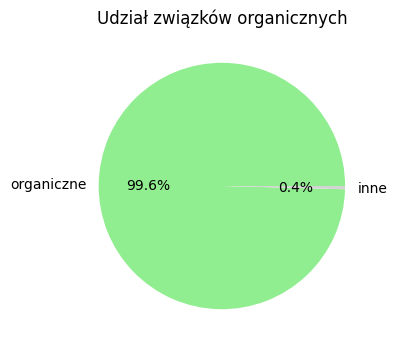

In [16]:
counts = data["is_organic"].value_counts()
plt.figure(figsize=(4,4))
plt.pie(counts, labels=["organiczne","inne"], autopct="%.1f%%", colors=["lightgreen","lightgray"])
plt.title("Udział związków organicznych")
plt.savefig("organic_pie.png", dpi=150)
plt.show()

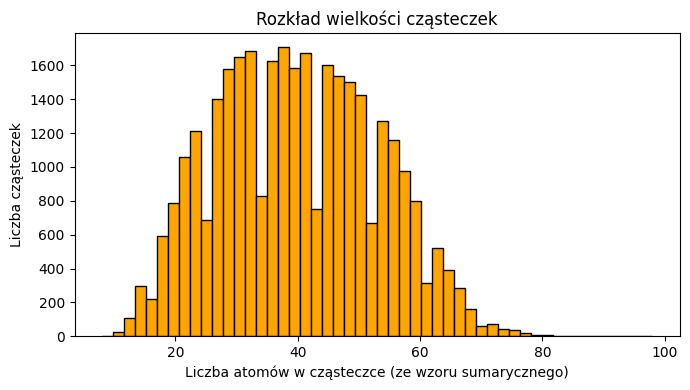

In [17]:
import re

def atom_count(formula):
    nums = re.findall(r"\d+", str(formula))
    return sum(map(int, nums)) if nums else None

data["atom_count"] = data["molecular_formula"].map(atom_count)

plt.figure(figsize=(7,4))
plt.hist(data["atom_count"].dropna(), bins=50, color="orange", edgecolor="black")
plt.xlabel("Liczba atomów w cząsteczce (ze wzoru sumarycznego)")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład wielkości cząsteczek")
plt.tight_layout()
plt.savefig("atom_count_hist.png", dpi=150)
plt.show()

Przykładowy SMILES:

In [9]:
med = data["smiles"].str.len().median()
one = data.iloc[(data["smiles"].str.len() - med).abs().argsort()[:1]][["smiles","molecular_formula"]]
print(one.to_dict(orient="records")[0])

{'smiles': 'CCC(=O)N(C)c1ccc2oc(-c3ccc(Cl)cc3)nc2c1', 'molecular_formula': 'C17H15ClN2O2'}


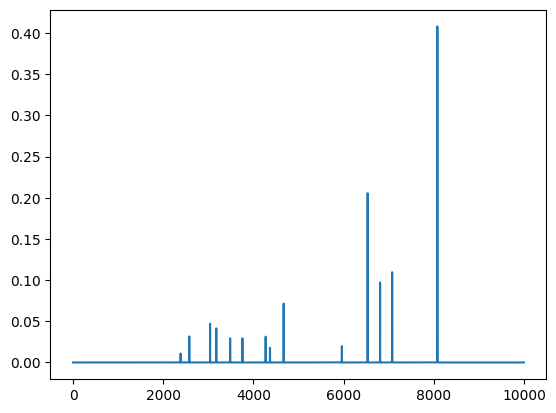

In [ ]:
# TBD: Osobny dataset z obrazami spektrów NMR (uzupelnienie do SMILES i SELFIES)
plt.plot(data["c_nmr_spectra"][0])

In [ ]:
# Przykładowa konwersja SMILES -> SELFIES
smiles = list(data['smiles'])

for i in range(10):
    selfie = sf.encoder(smiles[i])
    print(selfie)

[C][C][Branch1][C][C][Branch1][C][C][O][C][=Branch1][C][=O][/C][=C][/C][=C][C][=C][Branch1][#C][N][C][=Branch1][C][=O][C][N][C][C][O][C][C][Ring1][=Branch1][N][=C][Ring1][S]
[C][O][C][=C][C][=C][Branch2][Ring1][Ring1][C][C][=Branch1][Ring1][=N][O][C][=C][C][=C][Branch1][Ring1][O][C][C][=C][Ring1][Branch2][C][=C][Ring2][Ring1][C]
[C][O][C][=Branch1][C][=O][C][=C][C][=C][C][=C][C][Branch1][O][O][C][C][=C][C][=C][C][=C][Ring1][=Branch1][=C][C][Ring1][=C][=C][Ring2][Ring1][C]
[C][C][=C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][NH1][C][=Branch1][C][=O][N][Ring1][N][C][C][C][N][C][C][Ring1][=Branch1]
[C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][=Branch1][C][=Branch1][C][=O][O][C][Branch1][C][C][=C][Ring1][#Branch2]
[F][C][=C][C][=C][C][Branch1][#Branch2][N][C][C][C][N][C][C][Ring1][=Branch1][=C][Ring1][=N]
[C][N][C][=N][C][Branch1][S][C][=C][C][=C][Branch1][Ring1][C][#N][C][Branch1][C][F][=C][Ring1][=Branch2][=C][C][Branch1][N][N][C][C][C][C@@H1][Branch1][C][N][C][Ring1]

### Konwersja: SMILES → SELFIES → CSV (streamingowo po wszystkich plikach) - nowy, lżejszy dataset tekstowy

In [ ]:
###### DON'T RUN THIS CELL UNLESS YOU WANT TO OVERWRITE THE CSV FILE ######
DATA_DIR = "multimodal_spectroscopic_dataset"
OUT_CSV = "smiles_selfies_full.csv"

# znajdź i posortuj pliki .parquet liczbowo po numerze chunku
paths = glob.glob(os.path.join(DATA_DIR, "*.parquet"))
paths = sorted(paths, key=lambda x: int(re.findall(r"(\d+)", x)[-1]))

print("Znaleziono plików:", len(paths))

# otwieramy plik CSV raz, dopisujemy w pętli
with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["smiles", "selfies"])  # nagłówek

    for p in paths:
        # wczytujemy tylko kolumnę 'smiles'
        df = pd.read_parquet(p, columns=["smiles"])
        print(os.path.basename(p), "->", len(df), "wierszy")

        for smi in df["smiles"]:
            if not isinstance(smi, str):
                continue
            try:
                # strict=False = nie wywali się na dziwnych SMILESach
                selfie = sf.encoder(smi, strict=False)
            except Exception:
                selfie = ""  # albo np. "[INVALID]"

            writer.writerow([smi, selfie])

        del df

print("Zapisano pełny plik CSV:", OUT_CSV)

Znaleziono plików: 245
aligned_chunk_0.parquet -> 3235 wierszy
aligned_chunk_1.parquet -> 3273 wierszy
aligned_chunk_2.parquet -> 3129 wierszy
aligned_chunk_3.parquet -> 3226 wierszy
aligned_chunk_4.parquet -> 3280 wierszy
aligned_chunk_5.parquet -> 3292 wierszy
aligned_chunk_6.parquet -> 3233 wierszy
aligned_chunk_7.parquet -> 3211 wierszy
aligned_chunk_8.parquet -> 3225 wierszy
aligned_chunk_9.parquet -> 3222 wierszy
aligned_chunk_10.parquet -> 3244 wierszy
aligned_chunk_11.parquet -> 3270 wierszy
aligned_chunk_12.parquet -> 3249 wierszy
aligned_chunk_13.parquet -> 3243 wierszy
aligned_chunk_14.parquet -> 3239 wierszy
aligned_chunk_15.parquet -> 3204 wierszy
aligned_chunk_16.parquet -> 3276 wierszy
aligned_chunk_17.parquet -> 3378 wierszy
aligned_chunk_18.parquet -> 3281 wierszy
aligned_chunk_19.parquet -> 3262 wierszy
aligned_chunk_20.parquet -> 3254 wierszy
aligned_chunk_21.parquet -> 3241 wierszy
aligned_chunk_22.parquet -> 3240 wierszy
aligned_chunk_23.parquet -> 3296 wierszy
ali

In [8]:
# Test przy wczytaniu
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("smiles_selfies_full.csv")
df.head()      # pierwsze 5 wierszy

,smiles,selfies
0,O=S(O)c1cc2c(cc1F)OC(c1ccc(F)cc1F)(c1ccc(F)cc1F)O2,[O][=S][Branch1][C][O][C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][F][O][C][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][O][Ring2][Ring1][Branch2]
1,CN(C)Cc1cccc(C2Nc3cccc4c(=O)[nH]nc(c34)C2c2ccccc2)c1,[C][N][Branch1][C][C][C][C][=C][C][=C][C][Branch2][Ring1][P][C][N][C][=C][C][=C][C][C][=Branch1][C][=O][NH1][N][=C][Branch1][=Branch1][C][Ring1][O][=Ring1][#Branch1][C][Ring1][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][=C][Ring2][Ring1][#Branch2]
2,O=C(N[C@@H](CO)c1nc2cc(Cl)ccc2[nH]1)c1ccc(C(=O)N2CC=CC2)c(Br)c1,[O][=C][Branch2][Ring1][#Branch1][N][C@@H1][Branch1][Ring1][C][O][C][=N][C][=C][C][Branch1][C][Cl][=C][C][=C][Ring1][#Branch1][NH1][Ring1][#Branch2][C][=C][C][=C][Branch1][N][C][=Branch1][C][=O][N][C][C][=C][C][Ring1][Branch1][C][Branch1][C][Br][=C][Ring1][=C]
3,O=C(Cn1cc(I)cn1)N1CCCc2c1cnn2-c1ccc(F)cc1,[O][=C][Branch1][N][C][N][C][=C][Branch1][C][I][C][=N][Ring1][=Branch1][N][C][C][C][C][=C][Ring1][=Branch1][C][=N][N][Ring1][Branch1][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1]
4,Cc1ccc(-c2ccnc(Cl)c2)n1CC(=O)OCc1ccccc1,[C][C][=C][C][=C][Branch1][N][C][=C][C][=N][C][Branch1][C][Cl][=C][Ring1][#Branch1][N][Ring1][N][C][C][=Branch1][C][=O][O][C][C][=C][C][=C][C][=C][Ring1][=Branch1]


## Tokenizacja SELFIES

Specjalne tokeny używane w modelu sekwencyjnym:

| Token     | Znaczenie                     |
|-----------|-------------------------------|
| &lt;bos&gt; | beginning of sequence         |
| &lt;eos&gt; | end of sequence               |
| &lt;pad&gt; | padding (wyrównanie długości) |
| &lt;unk&gt; | unknown token                 |

Przykładowe tokeny SELFIES:

[’[C]’, ‘[C]’, ‘[O]’, ‘[Branch1_1]’, ‘[C]’]

Po dodaniu tokenów specjalnych i padding'u do jednakowej długości:


| Token        | Indeks |
|--------------|---------|
| &lt;bos&gt;        | 1       |
| [C]          | 10      |
| [C]          | 10      |
| [O]          | 23      |
| [Branch1_1]  | 41      |
| [C]          | 10      |
| &lt;eos&gt;        | 2       |
| &lt;pad&gt;        | 0       |
| &lt;pad&gt;        | 0       |
| ...          | ...       |

In [ ]:
def tokenize_selfies(selfies_str):
    ''' Zwraca listę tokenów SELFIES, 
    np. '[C][O][Branch1_1]' -> ['[C]', '[O]', '[Branch1_1]']
    '''
    return list(sf.split_selfies(selfies_str))

#  Build stoi and itos dictionaries from the entire list of SELFIES strings.
def build_vocabulary(selfies_list):
    ''' 
    stoi: token -> index
    itos: index -> token
    '''

    token_counter = Counter()

    # Count all tokens in the dataset
    for selfies_string in selfies_list:
        tokens = tokenize_selfies(selfies_string)
        token_counter.update(tokens)

    # Sequence model's tokens (zbiór specjalnych tokenów sekwencyjnych)
    sequence_tokens = ["<pad>", "<bos>", "<eos>", "<unk>"]
        
    itos = []
    for t in sequence_tokens:
        itos.append(t)

    for token, _ in token_counter.most_common():
        itos.append(token)

    # string-to-index
    stoi = {}
    idx = 0
    for token in itos:
        stoi[token] = idx
        idx += 1

    return stoi, itos

# Convert a SELFIES string into a sequence of token indices
def selfies_to_indices(selfies_string, stoi, max_length=100):
    
    tokens = tokenize_selfies(selfies_string)
    sequence = ["<bos>"] + tokens + ["<eos>"]
    
    # przycięcie
    if len(sequence) > max_length:
        sequence = sequence[:max_length]

    # Convert tokens -> indices
    indices = []
    for token in sequence:
        if token in stoi:
            indices.append(stoi[token])
        else:
            indices.append(stoi["<unk>"])

    # Add padding if too short
    if len(indices) < max_length:
        indices.append(stoi["<pad>"])
        
    return indices

def batch_selfies_to_tensor(selfies_batch, stoi, max_length=100):
    """
    Convert a list of SELFIES strings into a tensor (batch_size, max_length).
    """
    batch_indices = []
    for s in selfies_batch:
        idx_seq = selfies_to_indices(s, stoi, max_length)
        batch_indices.append(idx_seq)

    return torch.tensor(batch_indices, dtype=torch.long)

In [15]:
# Pobranie kolumny 'selfies' jako lista (lista tysięcy SELFIES stringów)
selfies_list = df["selfies"].tolist()

# bierzemy pierwszy SELFIES z kolumny
single_selfies = df["selfies"].iloc[0]
print("SELFIES:", single_selfies)

SELFIES: [O][=S][Branch1][C][O][C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][F][O][C][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][O][Ring2][Ring1][Branch2]


In [18]:
# Budowa słowników stoi i itos
stoi, itos = build_vocabulary([single_selfies])
print("string-to-index:", stoi)
print("Vocab size:", len(stoi))

string-to-index: {'<pad>': 0, '<bos>': 1, '<eos>': 2, '<unk>': 3, '[C]': 4, '[=C]': 5, '[Branch1]': 6, '[F]': 7, '[O]': 8, '[Ring1]': 9, '[=Branch1]': 10, '[=N]': 11, '[#Branch1]': 12, '[=S]': 13, '[Ring2]': 14, '[Branch2]': 15}
Vocab size: 16


In [20]:
indices = selfies_to_indices(single_selfies, stoi, max_length=80)
tensor = torch.tensor([indices], dtype=torch.long)

## Enkoder i dekoder w VAE za pomocą GRU
### SELFIES -> [GRU Encoder] -> z -> [GRU Decoder] -> SELFIES